In [1]:
from cmath import log
import os,random
import numpy as np
import tensorflow as tf
import argparse
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch

## Installing URSABench and required dependencies

In [2]:
!pip install git+https://github.com/AdamCobb/hamiltorch
!pip install botorch
!pip install git+https://github.com/reml-lab/URSABench
!pip install wandb
!pip install scikit-learn==0.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-jog2l_0w
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-jog2l_0w
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev1-py3-none-any.whl size=20130 sha256=e90146f8d23bc562dc0fa324be80a2265122d3d18a5a87ec11a4136e2da5dc2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lj_fp5em/wheels/94/33/56/4cf57b40759f68de688e5e01bee26d036f98048a16a9733e9b
Successfully built hamiltorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 25.5 MB/s 
     |████████████████████████████████| 718 kB 57.4 MB/s 
     |████████████████████████████████| 361 kB 69.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rem

In [3]:
import torchvision
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='../../data/', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]),)
mnist_testset = datasets.MNIST(root='../../data/', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

N_tr = 100
N_val = 1000

# print(mnist_trainset.data.shape)

batch_size_train = N_tr
batch_size_test = N_val
shuffle = True 

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=shuffle,num_workers=4)
val_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=False,num_workers=4)
test_loader = val_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
import torch.nn.functional as F

def evaluate(model, val_loader):
  model.eval()
  predictions = []
  total_loss = 0.
  num_test_examples = 0
  labels = []
  for val_data, val_labels in val_loader:
    val_logits = model(val_data.to(device))
    val_loss = F.cross_entropy(val_logits.cpu(), val_labels)
    val_predictions = torch.argmax(val_logits, dim=-1)
    predictions.append(val_predictions.cpu())
    labels.append(val_labels)
    num_test_examples += len(val_labels)
    total_loss += val_loss.item() * len(val_labels)
  predictions = torch.cat(predictions, dim=0)
  labels = torch.cat(labels, dim=0)
  avg_loss = total_loss / num_test_examples
  accuracy = torch.sum(predictions==labels).item()/len(labels)
  return predictions, avg_loss, accuracy

In [7]:
from torch.optim import Adam, lr_scheduler
from copy import deepcopy
from URSABench import models, inference, tasks, datasets, util

model_cfg = getattr(models, "MLP200MNIST")
num_train_epochs = 10
num_classes = 10
# model = Feedforward(400, 600, 3).to(device)
# model = LSTMNet(num_layers=5, hidden_size=100).to(device)
model = model_cfg.base(*model_cfg.args, num_classes=num_classes,
                       **model_cfg.kwargs).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
for epoch in range(num_train_epochs):
  model.train()
  total_epoch_loss = 0.
  num_train_examples = 0
  for batch_data, batch_labels in train_loader:
    optimizer.zero_grad()
    batch_logits = model(batch_data.to(device))
    loss = F.cross_entropy(batch_logits, batch_labels.to(device))
    loss.backward()
    optimizer.step()
    total_epoch_loss += loss.cpu().item()
    num_train_examples += len(batch_labels)
  print("Avg. epoch loss: %f" % (total_epoch_loss/num_train_examples))
  val_predictions, val_loss, val_accuracy = evaluate(model, val_loader)
  scheduler.step(val_loss)
  print("Avg. val loss: %f, avg. val accuracy: %f" % (val_loss, val_accuracy))

sgd_model = deepcopy(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg. epoch loss: 0.002549
Avg. val loss: 0.114757, avg. val accuracy: 0.965700
Avg. epoch loss: 0.001000
Avg. val loss: 0.100267, avg. val accuracy: 0.966400
Avg. epoch loss: 0.000694
Avg. val loss: 0.078161, avg. val accuracy: 0.976200
Avg. epoch loss: 0.000516
Avg. val loss: 0.073633, avg. val accuracy: 0.976800
Avg. epoch loss: 0.000444
Avg. val loss: 0.064298, avg. val accuracy: 0.978800
Avg. epoch loss: 0.000352
Avg. val loss: 0.069814, avg. val accuracy: 0.979300
Avg. epoch loss: 0.000338
Avg. val loss: 0.063326, avg. val accuracy: 0.980800
Avg. epoch loss: 0.000249
Avg. val loss: 0.078119, avg. val accuracy: 0.977200
Avg. epoch loss: 0.000252
Avg. val loss: 0.089967, avg. val accuracy: 0.975200
Avg. epoch loss: 0.000241
Avg. val loss: 0.071814, avg. val accuracy: 0.979800


In [8]:
pretrained_weights = model.state_dict()

## cSGHMC using URSABench

In [10]:
from URSABench import inference, tasks, util

model = model.to(device)



csghmc_hyperparams = {"lr_0": 0.06825362145900726, 
                      "prior_std": 0.33042997121810913, 
                      "num_samples_per_cycle": 5, 
                      "cycle_length": 22, 
                      "burn_in_epochs": 1, 
                      "num_cycles": 2, 
                      "alpha": 0.21256764233112335}


inference_object = inference.cSGHMC(csghmc_hyperparams, model, train_loader, device=device)
model_ensemble = inference_object.sample(val_loader=val_loader, debug_val_loss=True)

Epoch:  1  lr:  0.06790856388015641
{'train_loss': 0.01375732557028338, 'val_loss': 0.07419883739203215}
Epoch:  2  lr:  0.06687581107897475
{'train_loss': 0.005125946094388685, 'val_loss': 0.06223046137019992}
Epoch:  3  lr:  0.0651763830709962
{'train_loss': 0.003101137926648031, 'val_loss': 0.06045761196874082}
Epoch:  4  lr:  0.06284487530971752
{'train_loss': 0.0016407076797501456, 'val_loss': 0.0589283564593643}
Epoch:  5  lr:  0.059928750569645174
{'train_loss': 0.000966922402609877, 'val_loss': 0.05758729269728065}
Epoch:  6  lr:  0.05648737274107771
{'train_loss': 0.0008351074575572662, 'val_loss': 0.056884590769186616}
Epoch:  7  lr:  0.05259079835249061
{'train_loss': 0.0008708685687330823, 'val_loss': 0.05683005717583001}
Epoch:  8  lr:  0.0483183504216429
{'train_loss': 0.0008645608394544979, 'val_loss': 0.05655079917050898}
Epoch:  9  lr:  0.043757003667684195
{'train_loss': 0.0008828444079457161, 'val_loss': 0.05582607635296881}
Epoch:  10  lr:  0.03899961395668729
{'tra

## Evaluation on Prediction Task

In [15]:
from URSABench import tasks

task_object = tasks.Prediction({'in_distribution_test':test_loader}, num_classes=10, device=device, metric_list='ALL')
task_object.update_statistics([sgd_model], output_performance=False)
sgd_performance_metrics = task_object.get_performance_metrics()
sgd_performance_metrics

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'error_rate': 0.020199999999999996,
 'nll': 0.07078728824853897,
 'll': -0.07078728824853897,
 'brier_score': 0.03158384051112051,
 'ece': 0.010147109910845747,
 'misclass_model_uncertainty_auroc': 0.46175189319299353,
 'misclass_model_uncertainty_aucpr': 0.10209757339859842,
 'misclass_total_uncertainty_auroc': 0.9740015642715527,
 'misclass_total_uncertainty_aucpr': 0.4336342510848739,
 'misclass_confidence_auroc': 0.9736635482286746,
 'misclass_confidence_aucpr': 0.41452652198094014}

In [16]:
task_object = tasks.Prediction({'in_distribution_test':test_loader}, num_classes=10, device=device, metric_list='ALL')
task_object.update_statistics(model_ensemble, output_performance=False)
csghmc_performance_metrics = task_object.get_performance_metrics()
csghmc_performance_metrics

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'error_rate': 0.01529999999999998,
 'nll': 0.046301767230033875,
 'll': -0.046301767230033875,
 'brier_score': 0.022561936841220022,
 'ece': 0.006011398959159901,
 'misclass_model_uncertainty_auroc': 0.9831812349868013,
 'misclass_model_uncertainty_aucpr': 0.45339649980930796,
 'misclass_total_uncertainty_auroc': 0.9841715502083844,
 'misclass_total_uncertainty_aucpr': 0.5090741984411334,
 'misclass_confidence_auroc': 0.9840076039217014,
 'misclass_confidence_aucpr': 0.49161037514375905}

## Plot Results

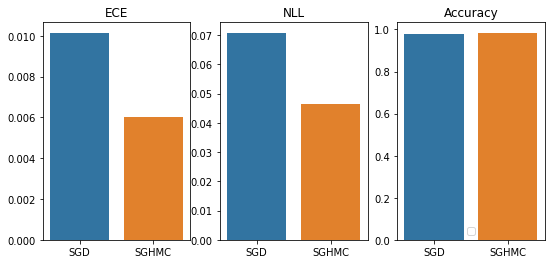

In [17]:
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
sns.barplot(x=['SGD', 'cSGHMC'], y=[sgd_performance_metrics['ece'], 
                                   csghmc_performance_metrics['ece']], ax=ax1)
ax1.set_title("ECE")
sns.barplot(x=['SGD', 'cSGHMC'], y=[sgd_performance_metrics['nll'], 
                                   csghmc_performance_metrics['nll']], ax=ax2)
ax2.set_title("NLL")
sns.barplot(x=['SGD', 'cSGHMC'], y=[1- sgd_performance_metrics['error_rate'], 
                                   1 - csghmc_performance_metrics['error_rate']], ax=ax3)
ax3.set_title("Accuracy")
plt.legend()